In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

### Negaive Binom

In [17]:
k, μ = 10, 100
xs = np.random.negative_binomial(k, p=k/(k+μ), size=100000)

In [16]:
zs = np.random.gamma(shape=k, scale=1/k, size=100000)
xs = np.random.poisson(μ*zs)

<AxesSubplot: ylabel='Count'>

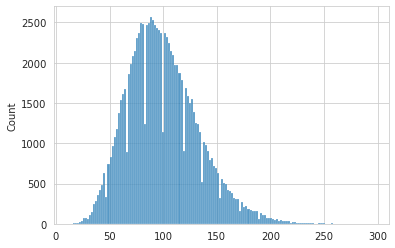

In [15]:
sns.histplot(xs)

<AxesSubplot: ylabel='Count'>

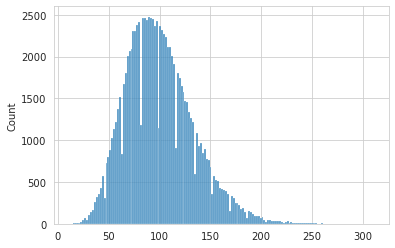

In [19]:
sns.histplot(xs)

## Test Statistics

In [270]:
def test_stat(x):
    mean = x.mean()
    return ((x - mean)**2).sum() / mean

n = 36
r = 1164
k = 2000
# k = 20

ts = []
for i in range(100000):
    u = np.random.dirichlet(np.ones(n)*k)
    x = np.random.multinomial(n=r, pvals=u)
    t = test_stat(x)
    ts.append(t)

ts = np.array(ts)

In [271]:
sample_mean = 1164 / n
t_obs = 1/sample_mean * (39508 - n*sample_mean**2)
t_obs

57.89690721649462

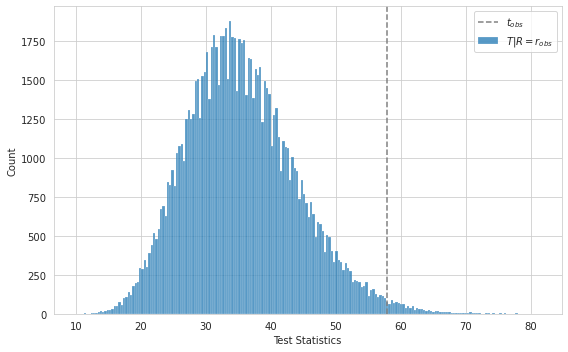

In [272]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(ts, ax=ax, bins=200, label='$T|R=r_{obs}$')
ax.axvline(t_obs, color='grey', linestyle='--', label='$t_{obs}$')
ax.set_xlabel('Test Statistics')
ax.legend()
fig.tight_layout()

In [273]:
(ts >= t_obs).mean()

0.01114

### Interval Rule

In [241]:
def test_stat2(xs):
    sums = xs.sum(1)
    return (xs**2).sum(1)/(sums/xs.shape[1]) - sums

def cond_p_value(tau, xs, n_samples=2000):
    # sufficient stats
    t_obs = test_stat(xs)
    r_obs = np.sum(xs)
    n = xs.shape[0]

    us = np.random.dirichlet(np.ones(n)*1/tau, size=n_samples)
    xs = np.c_[[np.random.multinomial(n=r_obs, pvals=us[i]) for i in range(n_samples)]]
    ts = test_stat2(xs)
    p = (ts >= t_obs).mean()

    return p

def interval(xs, taus, n_samples=1000):
    # estimate interval
    ps = []
    for tau_guess in taus:
        p = cond_p_value(tau_guess, xs, n_samples=n_samples)
        ps.append((tau_guess, p))

    # plotting
    sr = pd.DataFrame(ps, columns=('tau_guess','p')).set_index('tau_guess')['p']
    bound = sr[(sr<0.975)&(sr>0.025)].index
    return bound[0], bound[-1]

In [ ]:
coverage = []

In [301]:
# ground truth
n = 36
mu = 100
taus = np.linspace(0.0012, 0.05, 50) # guessess range

for i in range(2000):
    # tau = np.random.uniform(0.0012, 0.05)
    tau = np.random.uniform(0.02, 0.06) # truth
    zs = np.random.gamma(shape=1/tau, scale=k, size=n)
    xs = np.random.poisson(mu * zs)

    tau_bounds = interval(xs, taus, n_samples=1000)
    try:
        covered = (tau >= tau_bounds[0]) and (tau <= tau_bounds[-1])
    except IndexError:
        covered = False

    coverage.append((tau, covered))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [340]:
d = pd.DataFrame(coverage, columns=['tau','covered'])
d['bin'] = pd.cut(d.tau, bins=25).apply(lambda x: x.mid).astype(float)

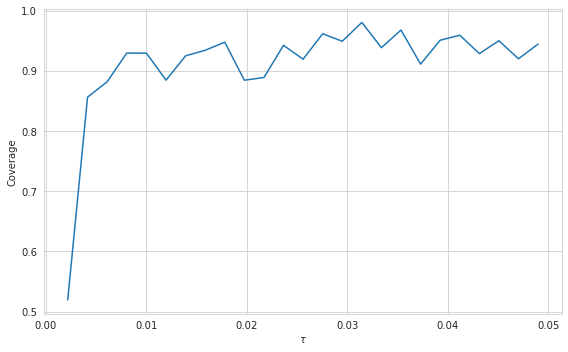

In [352]:
fig, ax = plt.subplots(figsize=(8, 5))

d.groupby('bin').covered.mean().plot(ax=ax)
ax.set_ylabel('Coverage')
ax.set_xlabel('$\\tau$')

fig.tight_layout()
fig.show()